In [1]:
## make plots inline - for ipython notebooks
%matplotlib inline

from numpy import linspace, sqrt, array, pi, cos, sin, dot, exp, sinh, log, log10, cosh, sinh
from numpy import atleast_1d, zeros, where, zeros_like
import numpy as np
from scipy.misc import derivative
import matplotlib.pyplot as plt
from pylab import loadtxt
from numpy.linalg import norm as norm
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from scipy import interpolate
import time
import math
import scipy.special as sp
from scipy import integrate
import matplotlib.ticker as ticker

import matplotlib
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
# Make use of TeX\ufeff
# rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':16, 'family':'serif','serif':['Times New Roman']})


# Change all fonts to 'Computer Modern'
rc('font',**{'size':16, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=10)
rc('xtick', labelsize=16)
rc('ytick.major', size=5, pad=10)
rc('ytick', labelsize=16)

plt.rcParams['figure.dpi'] = 125
plt.rcParams['savefig.dpi'] = 300

pcolors=['SteelBlue','Indigo','FireBrick','Coral','Tan','OliveDrab']

In [2]:
# running CLASS once to get various background quantities
k = 1.e-4  # 1/Mpc
common_settings = {'output':'mPk',
                   'k_output_values':k,
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.1201075,
                   'A_s':2.100549e-09 ,
                   'n_s':0.9660499,
                   'tau_reio':0.05430842,
                   'YHe':0.2454,
                   'compute damping scale':'yes',
                   'gauge':'newtonian'}  

M = Class()
M.set(common_settings)
M.compute()

derived = M.get_current_derived_parameters(['tau_rec','conformal_age','z_rec'])
thermo = M.get_thermodynamics()

z_rec = derived['z_rec']
tau_rec=derived['tau_rec']
tau_0=derived['conformal_age']
tau_0_minus_tau_rec_Mpc = (tau_0-tau_rec)
tau_reio=4255.316282

exp_kappa=thermo['exp(-kappa)']
tau = thermo['conf. time [Mpc]']
g = thermo['g [Mpc^-1]']

exp_kappa_func=interpolate.interp1d(tau,exp_kappa,kind='cubic')
g_func=interpolate.interp1d(tau,g,kind='cubic')

In [3]:
k_list=np.linspace(1.e-4,5.e-1,300) # change based on what k-space resolution you need, max=1000

#np.linspace(1.e-4,1.e-1,1000)
tau_list1=np.linspace(200,tau_rec,100) # change based on what tau-space resolution you need, max=100
tau_list2=np.linspace(tau_rec+1,1.e+3,300) # change based on what tau-space resolution you need, max=700
tau_list=np.concatenate((tau_list1,tau_list2))

tau_diff_list=tau_list[1:len(tau_list)]-tau_list[0:len(tau_list)-1] # time difference array needed to compute the Riemann sum

In [4]:
# running CLASS for each k and storing phi, psi, theta etc. outputs in arrays

phi_list=[]
psi_list=[]
theta_list=[]

phi_prime_list=[]
psi_prime_list=[]

for k in k_list:
    M.empty()
    common_settings = {'output':'mPk',
                   'k_output_values':k,
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.1201075,
                   'A_s':2.100549e-09 ,
                   'n_s':0.9660499,
                   'tau_reio':0.05430842,
                   'YHe':0.2454,
                   'compute damping scale':'yes', 
                   'gauge':'newtonian'} 
    M.set(common_settings)
    M.compute()
    all_k = M.get_perturbations()  
    one_k = all_k['scalar'][0]      
    tau_pert = one_k['tau [Mpc]']
    Theta0 = 0.25*one_k['delta_g']
    phi = one_k['phi']
    psi = one_k['psi']
    theta_b = one_k['theta_b']
    a = one_k['a']
    phi_func=interpolate.interp1d(tau_pert,phi,kind='cubic')
    psi_func=interpolate.interp1d(tau_pert,psi,kind='cubic')
    theta0_func=interpolate.interp1d(tau_pert,Theta0,kind='cubic')   
    
    phi_list.append(np.append(k,phi_func(tau_list))) # first index is the k value
    psi_list.append(np.append(k,psi_func(tau_list)))
    theta_list.append(np.append(k,theta0_func(tau_list)))    
    phi_prime_list.append(np.append(k,derivative(phi_func,tau_list,dx=0.1)))
    psi_prime_list.append(np.append(k,derivative(psi_func,tau_list,dx=0.1)))
    

KeyboardInterrupt: 

In [ ]:
## 99th entry gives tau_rec
tau_list[99]-tau_rec

In [ ]:
tau_diff_list=tau_list[1:len(tau_list)]-tau_list[0:len(tau_list)-1] # time difference array needed to compute the Riemann sum
k_diff_list=k_list[1:len(k_list)]-k_list[0:len(k_list)-1] # k difference array needed to compute Riemann sum

def func(x): # defines the curvature perturbation in momentum space
    return sp.sici(x)[0]-np.sin(x) #sici returns {si(x), ci(x)} as tuples

phidot=59**2
g=1
prefac=-g/phidot*(4*np.pi)/(2*np.pi)**3*2.7*1.e+6

### ISW Transfer function, need to evaluate only once

In [7]:
# ISW transfer function, f_ISW(k,l) in the draft

f_ISW = np.zeros_like(k_list)

for ell in np.arange(1,600):
    sum_over_k = []
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_time=exp_kappa_func(tau_list)*(psi_prime_list[n][1:len(tau_list)+1]+phi_prime_list[n][1:len(tau_list)+1])*sp.spherical_jn(ell,k_val*(tau_0-tau_list)) # the integrand for time integral
        integral_time=np.sum(integrand_time[0:len(integrand_time)-1]*tau_diff_list) # time integral done using Riemann sum
        sum_over_k.append(integral_time)
    f_ISW = np.vstack((f_ISW, sum_over_k))
        

### SW Transfer function, need to evaluate only once

In [8]:
# SW transfer function, f_SW(k,l) in the draft

f_SW = np.zeros_like(k_list)

for ell in np.arange(1, 2000):
    sum_over_k_SW = [] 
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_time_SW = (psi_list[n][99]+theta_list[n][99])*sp.spherical_jn(ell,k_val*(tau_0-tau_rec)) ## 99 implies evaluation at tau_rec
        sum_over_k_SW.append(integrand_time_SW)
    f_SW = np.vstack((f_SW, sum_over_k_SW))


### ISW for single eta_HS

In [9]:
# the full computation of ISW, with new tau_rec dependence, single etap and single eta_HS
eta_HS = tau_rec

etap=160
integrand_list=[]
ell_count=1
for ell in np.arange(1,600):
    sum_over_k=[]
    for n in range(len(k_list)): # loops over all k values for each ell
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val # the integrand for k integral
        sum_over_k.append(integrand_full) 
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list)) # k integral done using Riemann sum
    ell_count += 1

print('the ISW amplitude is',np.sum(integrand_list))  # finally summing over ell  

the ISW amplitude is 5.567161160751347


### SW for single eta_HS

In [10]:
# the full computation of SW piece, code structure same as ISW piece, new tau_rec dependence, single etap
eta_HS = tau_rec

etap=160
integrand_list=[]
ell_count=1
for ell in np.arange(1,2000):
    sum_over_k=[]
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0]        
        integrand_full=prefac*f_SW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
        sum_over_k.append(integrand_full)
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
    ell_count +=1

print('the SW amplitude is',np.sum(integrand_list))

the SW amplitude is 37.34049754329359


### Central temperature scan for different eta_HS, ISW piece

In [11]:
tau_rec

280.62745874925827

In [12]:
etap=160
ISW_central_list=[]

for eta_HS in np.linspace(tau_rec-etap, tau_rec+etap, 50):
    integrand_list=[]
    ell_count=1
    for ell in np.arange(1,600):
        sum_over_k=[]
        for n in range(len(k_list)): # loops over all k values for each ell
            k_val=psi_prime_list[n][0] # first value gives the k
            integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val # the integrand for k integral
            sum_over_k.append(integrand_full) 
        integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list)) # k integral done using Riemann sum
        ell_count += 1
    print('the ISW amplitude is',np.sum(integrand_list))  # finally summing over ell  
    ISW_central_list.append(np.sum(integrand_list))

the ISW amplitude is -0.42849288625622806
the ISW amplitude is -0.40032925577416045
the ISW amplitude is -0.3562665495490699
the ISW amplitude is -0.29297247565371404
the ISW amplitude is -0.20741081946497902
the ISW amplitude is -0.09739635974010385
the ISW amplitude is 0.0381297948060374
the ISW amplitude is 0.19914023050653437
the ISW amplitude is 0.38476075443222013
the ISW amplitude is 0.5935751001888889
the ISW amplitude is 0.8238962044725764
the ISW amplitude is 1.0739702794082715
the ISW amplitude is 1.3421103568797972
the ISW amplitude is 1.6267564133256935
the ISW amplitude is 1.92647693654833
the ISW amplitude is 2.239932697498121
the ISW amplitude is 2.5658136915935494
the ISW amplitude is 2.902753632772006
the ISW amplitude is 3.249233258963054
the ISW amplitude is 3.6034761388112306
the ISW amplitude is 3.9633390669818915
the ISW amplitude is 4.326191838038352
the ISW amplitude is 4.688804497871335
the ISW amplitude is 5.0472762206663875
the ISW amplitude is 5.39707082325

### Central temperature scan for different eta_HS, SW piece

In [13]:
etap=160
SW_central_list=[]

for eta_HS in np.linspace(tau_rec-etap, tau_rec+etap, 50):
    integrand_list=[]
    ell_count=1
    for ell in np.arange(1,2000):
        sum_over_k=[]
        for n in range(len(k_list)):
            k_val=psi_prime_list[n][0]        
            integrand_full=prefac*f_SW[ell_count][n]*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
            sum_over_k.append(integrand_full)
        integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
        ell_count +=1
    print('the SW amplitude is',np.sum(integrand_list))
    SW_central_list.append(np.sum(integrand_list))

the SW amplitude is -0.3068990097513077
the SW amplitude is 1.428253966029198
the SW amplitude is 3.6780458332928654
the SW amplitude is 6.061427032758577
the SW amplitude is 8.121602270301153
the SW amplitude is 9.678105303967094
the SW amplitude is 10.802055475642689
the SW amplitude is 11.683940784340397
the SW amplitude is 12.505895946307987
the SW amplitude is 13.335170676403962
the SW amplitude is 14.14591153192042
the SW amplitude is 14.90196987333788
the SW amplitude is 15.60851657229311
the SW amplitude is 16.306354728111252
the SW amplitude is 17.052222540616853
the SW amplitude is 17.898105542170185
the SW amplitude is 18.89284844742452
the SW amplitude is 20.08558105244186
the SW amplitude is 21.547100628991277
the SW amplitude is 23.378183066066754
the SW amplitude is 25.718578293735526
the SW amplitude is 28.66262286999008
the SW amplitude is 32.03607122837811
the SW amplitude is 35.15526982542862
the SW amplitude is 37.07781457906197
the SW amplitude is 37.07933967018749

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


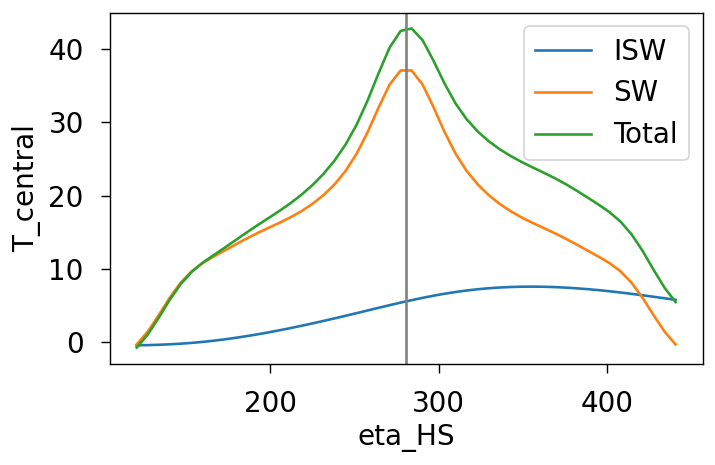

In [14]:
plt.plot(np.linspace(tau_rec-etap, tau_rec+etap, 50), ISW_central_list, label='ISW')
plt.plot(np.linspace(tau_rec-etap, tau_rec+etap, 50), SW_central_list, label='SW')
plt.plot(np.linspace(tau_rec-etap, tau_rec+etap, 50), np.array(SW_central_list)+np.array(ISW_central_list), label='Total')
plt.xlabel('eta_HS')
plt.ylabel('T_central')
plt.legend()
plt.axvline(x=tau_rec, color='gray')
plt.tight_layout()
plt.savefig('central_temp.pdf')

In [25]:
np.logspace(-4.0, -1.0, num=1)

array([0.0001])

### Temperature angular profilescan for different \eta_HS, SW piece

In [16]:
etap=160
eta_HS_arr = np.linspace(tau_rec-etap, tau_rec+etap, 50)
ang_arr = np.logspace(-3.7, -0.7, num=100)

SW_angle_arr=np.zeros_like(ang_arr)

for eta_HS in eta_HS_arr:
    print(eta_HS)
    SW_angle_temp = [] 
    for ang in ang_arr:
        
        integrand_list=[]
        ell_count=1
        for ell in np.arange(1,2000):
            sum_over_k=[]
            for n in range(len(k_list)):
                k_val=psi_prime_list[n][0]
                
                integrand_full=prefac*f_SW[ell_count][n]*func(k_val*etap)*sp.eval_legendre(ell,np.cos(ang))*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
                sum_over_k.append(integrand_full)
            integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
            ell_count +=1
        # print('the SW amplitude is',np.sum(integrand_list))
        SW_angle_temp.append(np.sum(integrand_list))
        
    SW_angle_arr = np.vstack((SW_angle_arr, SW_angle_temp))
    np.savetxt('SW_stack.txt', SW_angle_arr)

120.62745874925827
127.15807099415622
133.68868323905417
140.21929548395215
146.7499077288501
153.28051997374806
159.81113221864604
166.341744463544
172.87235670844194
179.4029689533399
185.93358119823785
192.46419344313583
198.99480568803378
205.52541793293173
212.0560301778297
218.58664242272766
225.11725466762562
231.64786691252357
238.17847915742152
244.7090914023195
251.23970364721745
257.7703158921154
264.3009281370134
270.83154038191134
277.3621526268093
283.89276487170724
290.4233771166052
296.9539893615032
303.48460160640116
310.0152138512991
316.54582609619706
323.076438341095
329.60705058599297
336.1376628308909
342.66827507578887
349.1988873206868
355.7294995655848
362.2601118104827
368.79072405538074
375.3213363002787
381.85194854517664
388.3825607900746
394.91317303497254
401.4437852798705
407.9743975247685
414.50500976966646
421.0356220145644
427.56623425946236
434.0968465043603
440.62745874925827


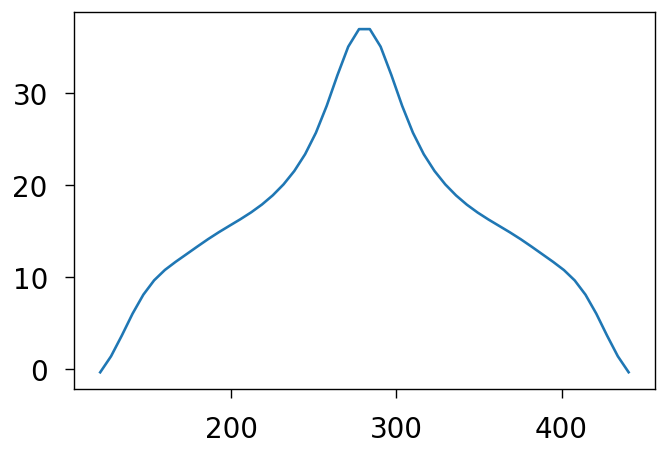

In [17]:
plt.plot(eta_HS_arr, SW_angle_arr.T[0][1:])

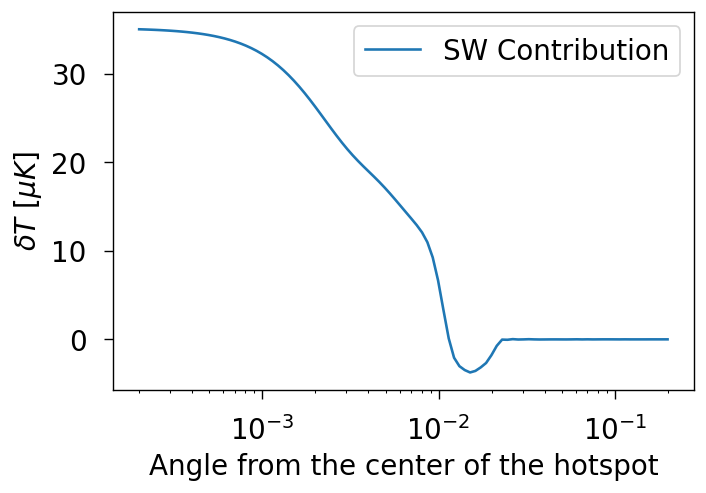

In [18]:
plt.plot(ang_arr, SW_angle_arr[24], label='SW Contribution')
plt.xscale('log')
plt.xlabel('Angle from the center of the hotspot')
plt.ylabel('$\delta T~[\mu K]$')
plt.legend()

### Temperature angular profilescan for different \eta_HS, ISW piece

In [25]:
etap=160
eta_HS_arr = np.linspace(tau_rec-etap, tau_rec+etap, 50)
ang_arr = np.logspace(-3.7, -0.7, num=100)

ISW_angle_arr=np.zeros_like(ang_arr)

for eta_HS in eta_HS_arr:
    ISW_angle_temp = [] 
    for ang in ang_arr:
        
        integrand_list=[]
        ell_count=1
        for ell in np.arange(1,600):
            sum_over_k=[]
            for n in range(len(k_list)):
                k_val=psi_prime_list[n][0]
                
                integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.eval_legendre(ell,np.cos(ang))*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
                sum_over_k.append(integrand_full)
            integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
            ell_count +=1
        # print('the SW amplitude is',np.sum(integrand_list))
        ISW_angle_temp.append(np.sum(integrand_list))
        
    ISW_angle_arr = np.vstack((ISW_angle_arr, ISW_angle_temp))

In [26]:
np.savetxt('ISW_stack.txt', ISW_angle_arr)

In [ ]:
ISW_angle_arr = np.loadtxt('../ISW_stack.txt')

In [ ]:
plt.plot(eta_HS_arr, ISW_angle_arr.T[0][1:])

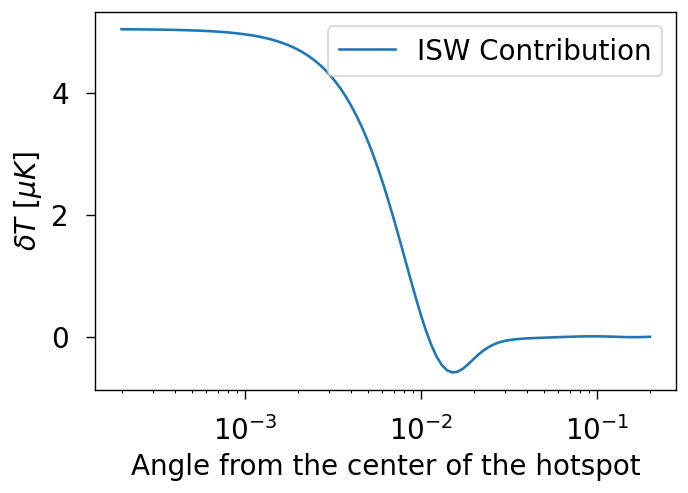

In [27]:
ang_arr = np.logspace(-3.7, -0.7, num=100)
plt.plot(ang_arr, ISW_angle_arr[24], label='ISW Contribution')
plt.xscale('log')
plt.xlabel('Angle from the center of the hotspot')
plt.ylabel('$\delta T~[\mu K]$')
plt.legend()

In [28]:
eta_HS_arr[24]

277.3621526268093

# Old

In [52]:
etap=160
eta_HS_arr = np.linspace(tau_rec-etap, tau_rec+etap, 5)
ang_arr = np.linspace(0.07, 0.2, num=10)

ISW_angle_arr_n=np.zeros_like(ang_arr)

for eta_HS in eta_HS_arr:
    ISW_angle_temp = [] 
    for ang in ang_arr:
        
        integrand_list=[]
        ell_count=1
        for ell in np.arange(1,600):
            sum_over_k=[]
            for n in range(len(k_list)):
                k_val=psi_prime_list[n][0]
                
                integrand_full=prefac*f_ISW[ell_count][n]*func(k_val*etap)*sp.eval_legendre(ell,np.cos(ang))*sp.spherical_jn(ell,k_val*(tau_0-eta_HS))*(2*ell+1)/k_val
                sum_over_k.append(integrand_full)
            integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))
            ell_count +=1
        # print('the SW amplitude is',np.sum(integrand_list))
        ISW_angle_temp.append(np.sum(integrand_list))
        
    ISW_angle_arr_n = np.vstack((ISW_angle_arr_n, ISW_angle_temp))

In [45]:
# the full computation of ISW, with new tau_rec dependence, single etap and single eta_HS
eta_HS = tau_rec

etap=160
integrand_list=[]
for ell in np.arange(20,600):
    sum_over_k=[]
    for n in range(len(k_list)): # loops over all k values for each ell
        k_val=psi_prime_list[n][0] # first value gives the k
        integrand_time=exp_kappa_func(tau_list)*(psi_prime_list[n][1:len(tau_list)+1]+phi_prime_list[n][1:len(tau_list)+1])*sp.spherical_jn(ell,k_val*(tau_0-tau_list)) # the integrand for time integral
        integral_time=np.sum(integrand_time[0:len(integrand_time)-1]*tau_diff_list) # time integral done using Riemann sum
        
        integrand_full=prefac*integral_time*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-tau_rec))*(2*ell+1)/k_val # the integrand for k integral
        sum_over_k.append(integrand_full) 
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list)) # k integral done using Riemann sum

print('the ISW amplitude is',np.sum(integrand_list))  # finally summing over ell  

the ISW amplitude is 5.611001349298974


In [11]:
# the full computation of SW piece, code structure same as ISW piece, new tau_rec dependence, single etap
etap=160
integrand_list=[]
for ell in np.arange(20,2000):
    sum_over_k=[]
    for n in range(len(k_list)):
        k_val=psi_prime_list[n][0]
        integrand_time=g_func(tau_list)*(psi_list[n][1:len(tau_list)+1]+theta_list[n][1:len(tau_list)+1])*sp.spherical_jn(ell,k_val*(tau_0-tau_list))
        integral_time=np.sum(integrand_time[0:len(integrand_time)-1]*tau_diff_list)
        
        integrand_full=prefac*integral_time*func(k_val*etap)*sp.spherical_jn(ell,k_val*(tau_0-tau_rec))*(2*ell+1)/k_val
        sum_over_k.append(integrand_full)
    integrand_list.append(np.sum(sum_over_k[0:len(sum_over_k)-1]*k_diff_list))

print('the SW amplitude is',np.sum(integrand_list))    

the SW amplitude is 28.663737220837334
